# Radar-adjustement for OpenMRG dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))

import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pycomlink.processing.wet_dry.mlp as mlp

/home/erlend/miniforge3/envs/opensense_training/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/erlend/miniforge3/envs/opensense_training/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 1. Load and explore the data

In [3]:
# Fetches 8 days from OpenRainER dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges,
) = plg.example_data.load_openrainer(data_dir="example_data", subset="8d")

ds_rad = ds_rad.rename({'R':'rainfall_radar'})
ds_rad = ds_rad.rename({'R_gauge_adjusted':'rainfall_gauge_adjusted'})

# Load data, faster processing below
ds_rad = ds_rad.load()
ds_cmls = ds_cmls.load()
ds_gauges = ds_gauges.load()

File already exists at example_data/openrainer_cml_8d.nc
Not downloading!
File already exists at example_data/openrainer_radar_8d.nc
Not downloading!
File already exists at example_data/openrainer_gauges_8d.nc
Not downloading!


In [4]:
cml_load = xr.open_dataset('/home/erlend/Downloads/max_proc_cml_radar_wet_dry.nc')

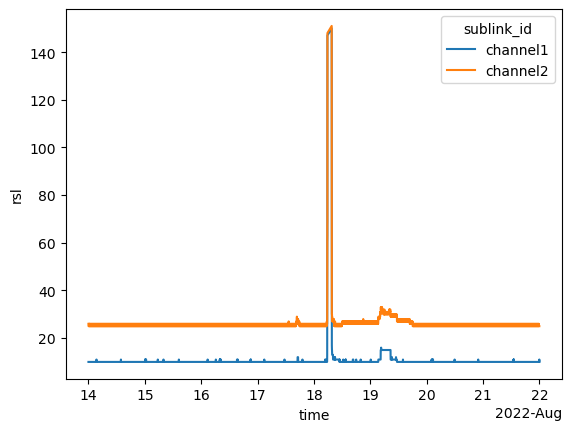

In [5]:
np.isnan(ds_cmls).sum(dim = 'cml_id').rsl.plot.line(x='time')

In [6]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Plot raw time series

Text(0.5, 1.0, 'Rain gauges')

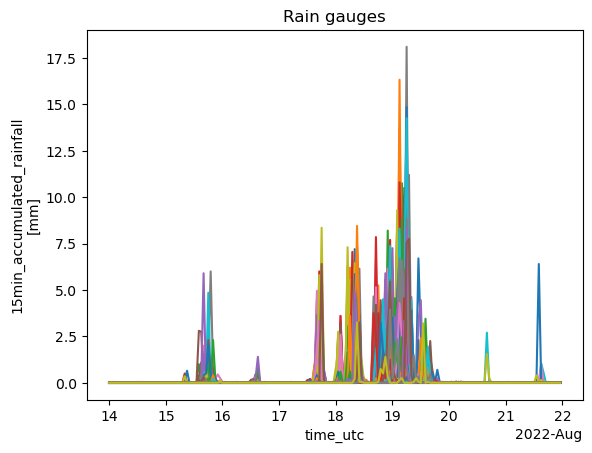

In [7]:
ds_gauges.rainfall_amount.resample(time='1h').mean().plot.line(x='time', add_legend=False);
plt.title('Rain gauges')

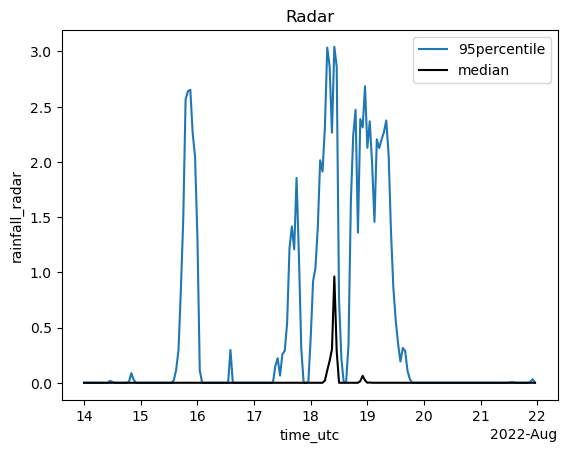

In [8]:
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.95, dim=['x', 'y']).plot(color = 'C0', label='95percentile');
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.5, dim=['x', 'y']).plot(color = 'k', label='median');
plt.title('Radar')
plt.legend()

### CML preprocessing 

In [9]:
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl

In [10]:
# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal cycles
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.35

ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)
ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)


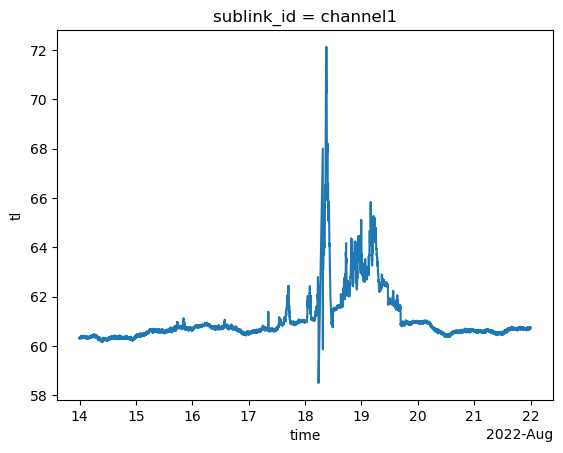

In [11]:
ds_cmls.tl.mean(dim ='cml_id').plot()

### CML processing using radar wet

In [12]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad.rainfall_radar,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()
ds_cmls['wet'] = ds_cmls.wet.ffill(dim='time')

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=3,
    zeta=0.7,
    d=0.15,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,
    f_GHz=ds_cmls.frequency / 1000,
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

In [13]:
ds_cmls.cml_id.size

103

In [14]:
da_radar_along_cmls.cml_id.size

103

### Resample units of reference data to common resolution

In [15]:
time_resample = '60min'
ds_rad_resampled = (ds_rad[['rainfall_radar']]).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_gauges_resampled = (ds_gauges[['rainfall_amount']]).resample(time=time_resample, label='right', closed='right').sum() # from sum 1min -> sum 15min 
ds_cmls_resampled = (ds_cmls[['R']]/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_rad_along_cml_resampled = da_radar_along_cmls.resample(time = time_resample, label='right', closed='right').sum()

In [16]:
start = '2022-08-18T08:00'
end = '2022-08-18T19:00'
#ds_cmls_resampled = ds_cmls_resampled.sel(time = slice(start, end))
#ds_rad_along_cml_resampled = ds_rad_along_cml_resampled.sel(time = slice(start, end))
#ds_rad_resampled = ds_rad_resampled.sel(time = slice(start, end)) 

In [17]:
# Remove CMLs that do not agree with radar.
ds_cmls_resampled = ds_cmls_resampled.transpose('time', 'cml_id')
cml_keep = []
for cml_id in ds_cmls_resampled.cml_id.data:
    radar_obs = ds_rad_along_cml_resampled.sel(cml_id = cml_id).data
    cml_obs = ds_cmls_resampled.sel(cml_id = cml_id).R.data

    is_nan = np.isnan(radar_obs) | np.isnan(cml_obs) 
    keep = ~is_nan
    rmse = np.mean((radar_obs[keep] - cml_obs[keep])**2)
    if (round(np.corrcoef(radar_obs[keep], cml_obs[keep])[0, 1], 2) > 0.8) & (rmse < 10):
        cml_keep.append(cml_id)

cml_keep = np.array(cml_keep)
ds_rad_along_cml_resampled = ds_rad_along_cml_resampled.sel(cml_id = cml_keep)
ds_cmls_resampled = ds_cmls_resampled.sel(cml_id = cml_keep)



/home/erlend/miniforge3/envs/opensense_training/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/erlend/miniforge3/envs/opensense_training/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


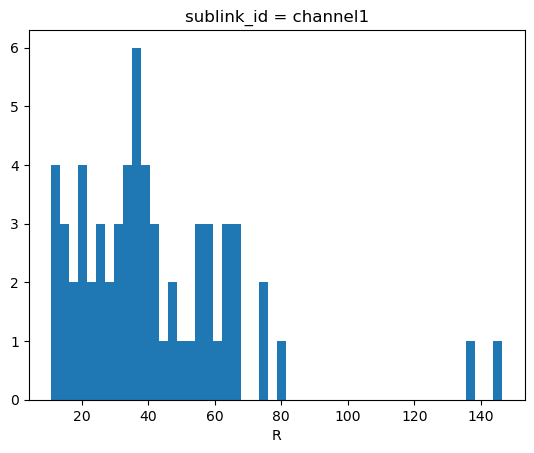

In [18]:
ds_cmls_resampled.R.sum(dim = 'time').plot.hist(bins=50);

In [19]:
keep = ds_cmls_resampled.R.sum(dim = 'time') < 120
ds_cmls_resampled = ds_cmls_resampled.sel(cml_id = keep)


### Interpolate CMLs all time steps

In [24]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateIDW()

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        interpolator.interpolate(
            da_grid = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]), #ds_cmls_resampled.R.sel(time = [time]),
            p=3, # IDW parameter
            nnear=25, # IDW number of nearest observations to use
            idw_method='standard',
            max_distance=20000,
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_interpolateIDW'] = xr.concat(rainfall_field, dim="time")

In [ ]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 0.9, "range": 30000, "nugget": 0.6}
variogram_model = "exponential"

# Number of neighbours to use for interpolation
nnear = 8

# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging()

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        interpolator.interpolate(
            da_grid = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]), #ds_cmls_resampled.R.sel(time = [time]),
            full_line=True,
            variogram_parameters=variogram_parameters,
            nnear=nnear,
        )
    )
ds_rad["rainfall_interpolateBKline"] = xr.concat(rainfall, dim="time")

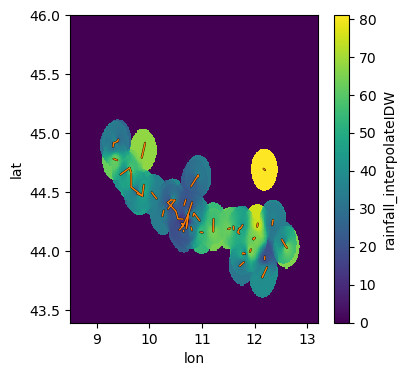

In [25]:
# Plot map
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plg.plot_map.plot_plg(
    da_grid=ds_rad_resampled['rainfall_interpolateIDW'].sum(dim='time'),
    #da_gauges=da_gauges_municp_15min.isel(time = t),
    #da_cmls=da_cmls_15min.isel(time = 0),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,
    cmap='viridis',
    ax=ax
)

# Plot CMLs
plg.plot_map.plot_lines(ds_cmls_resampled.isel(time = 0), use_lon_lat=True, ax=ax, line_color= 'C1');

# PLot rain gauges
#ax.plot(ds_gauges_resampled.lon, ds_gauges_resampled.lat, 'kx')

### Exercises
1. Plot accumulated rainfall map for radar (same as done for IDW interpolation in the cell above).
2. Compare the accumulated radar rainfall map with the accumulated CML IDW interpolated rainfall map. How do they differ?


In [80]:
get_grid_at_points = plg.spatial.GridAtPoints(
    ds_rad_resampled, 
    ds_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

ds_gauges_resampled['rainfall_interpolateIDW'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_interpolateIDW,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

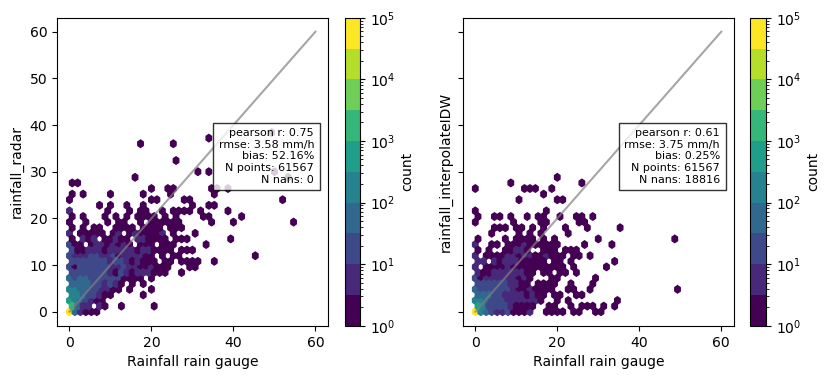

In [81]:
xmax = 20

# What fields to consider
rainfall_fields = [
    "rainfall_radar",
    "rainfall_interpolateIDW",
]

fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(4*len(rainfall_fields)*1.2, 4), sharex=True, sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    estimate = ds_gauges_resampled[rainfall_field].data.ravel()
    #ind_suffle = np.random.choice(np.arange(estimate.shape[0]), size = estimate.shape[0], replace=True)
    #estimate = estimate[ind_suffle,:].ravel()
    reference = ds_gauges_resampled.rainfall_amount.data.ravel()
        
    # Plot hexbin
    plg.validation.plot_hexbin(reference, estimate, ax=ax[i])
    
    threshold = 0.1 # values below are ignored
    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=reference,
        estimate=estimate,
        ref_thresh=threshold,
        est_thresh=threshold,
    )
    plotted_metrics = (
        f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )
    
    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )
    ax[i].set_ylabel(str(rainfall_field))
    ax[i].set_xlabel('Rainfall rain gauge')


# Merge data

In [82]:
# Import interpolator
merger = mrg.merge.MergeDifferenceIDW(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            p=2, # IDW parameter
            nnear=12, # number of nearest observations to use
            method='additive',
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_additiveIDW'] = xr.concat(rainfall_field, dim="time")

### Plot rainfall maps for some time steps

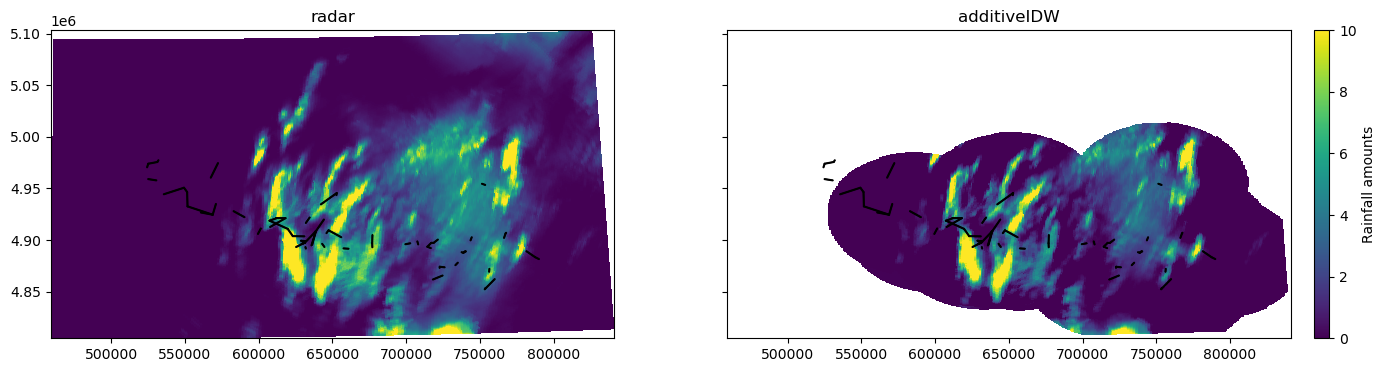

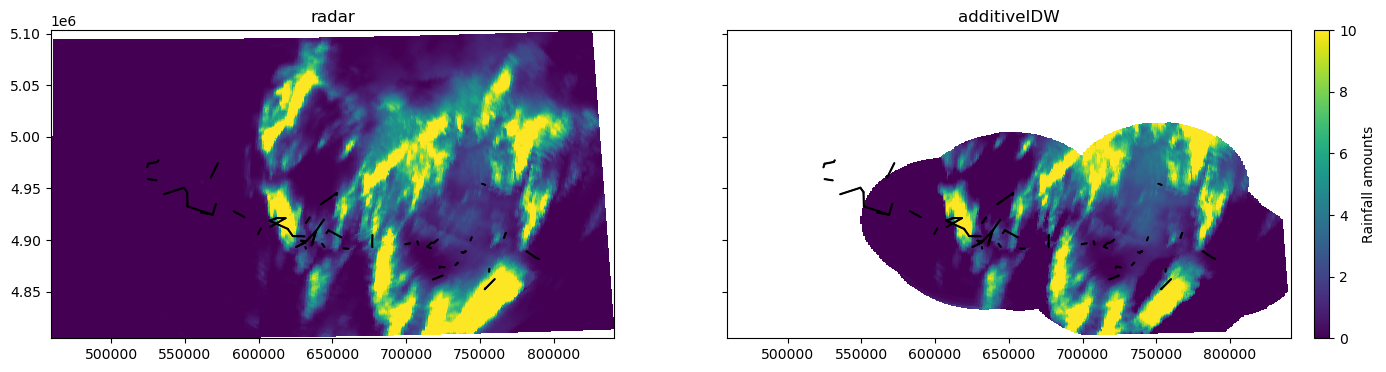

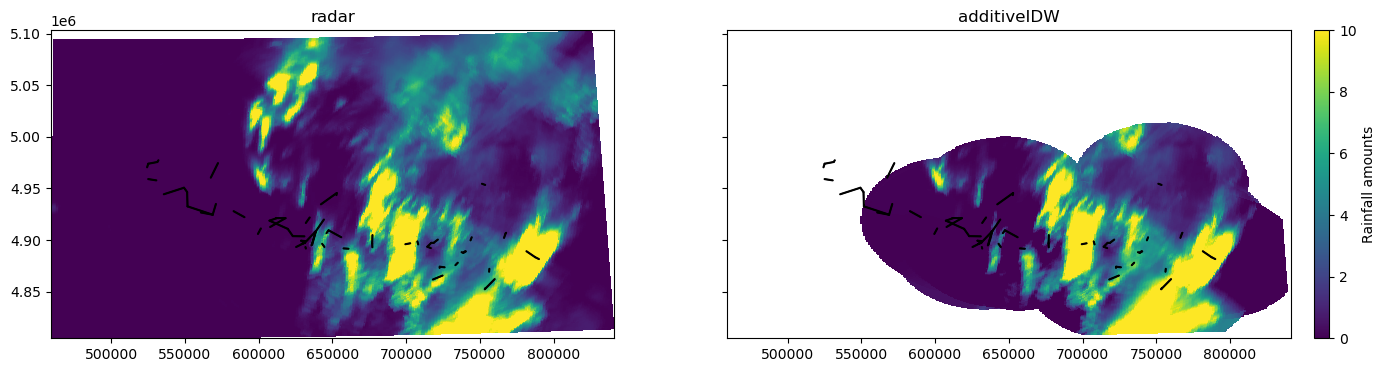

In [83]:
vmax = 10  # max color
cmap_rain = "viridis"
# Time interval to plot
time_start = '2022-08-18T21'
time_end = '2022-08-18T23'

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
]

for time in ds_rad_resampled.sel(time=slice(time_start, time_end)).time[:3]:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad_resampled.x_grid,
            ds_rad_resampled.y_grid,
            ds_rad_resampled[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap=cmap_rain,
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls_resampled,
            use_lon_lat=False,
            ax=ax[i],
            line_color="k",
        )

        ax[i].set_title(rainfall_field.split("_")[1])
        #ax[i].plot(ds_gauges_resampled.x, ds_gauges_resampled.y, 'xr')

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall amounts")
    plt.show()

### Evalute rainfall fields at rain gauge positions

In [84]:
get_grid_at_points = plg.spatial.GridAtPoints(
    ds_rad_resampled, 
    ds_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

ds_gauges_resampled['rainfall_additiveIDW'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_additiveIDW,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

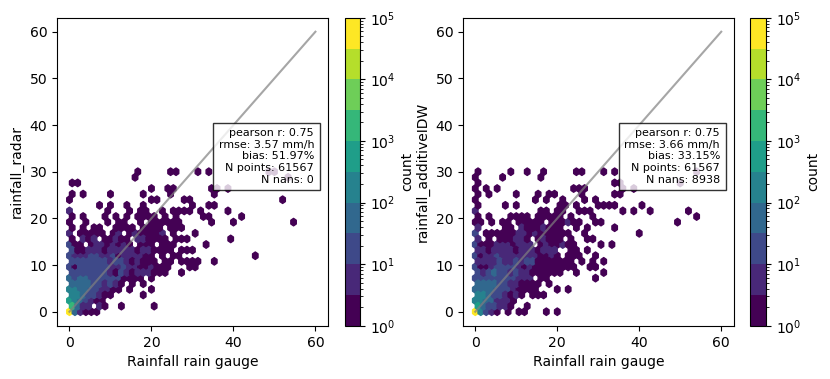

In [85]:
xmax = 20

# What fields to consider
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
]

fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(4*len(rainfall_fields)*1.2, 4))
for i, rainfall_field in enumerate(rainfall_fields):
    estimate = ds_gauges_resampled[rainfall_field].data.ravel()
    estimate[estimate > 30] = 30
    reference = ds_gauges_resampled.rainfall_amount.data.ravel()
        
    # Plot hexbin
    plg.validation.plot_hexbin(reference, estimate, ax=ax[i])
    
    threshold = 0.1 # values below are ignored
    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=reference,
        estimate=estimate,
        ref_thresh=threshold,
        est_thresh=threshold,
    )
    plotted_metrics = (
        f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )
    
    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )
    ax[i].set_ylabel(str(rainfall_field))
    ax[i].set_xlabel('Rainfall rain gauge')


### Exercises

1. Perform additive block kriging interpolation (OBK) of the data. Plot 3 time steps comparing radar, IDW and OBK maps. Hint: See code above for map and hexbin. Code below for block kriging.
2. Perform hexbinplots comparing the radar, IDW and OKB maps. Hint: Use the OBK maps you just created and use the code above to create a hexbin plot.
3. Test different kriging parameters, is there any parameters that works better? How does the range and nugget affect the resulting field. 
4. Experiment with multiplicative adjustment. Hint: Set "method = 'multiplicative', in the OBK code. 

In [ ]:
# Import interpolator
merger = mrg.merge.MergeDifferenceOrdinaryKriging(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0.2},
            nnear=12,
            full_line=True, #
            method='additive'
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_adjustOBK'] = xr.concat(rainfall_field, dim="time")


In [ ]:
ds_gauges_resampled['rainfall_adjustOBK'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_adjustOBK,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

In [ ]:
xmax = 20
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
reference = ds_gauges_resampled.rainfall_amount.data.ravel()
estimate = ds_gauges_resampled.rainfall_adjustOBK.data.ravel()

# Plot hexbin
plg.validation.plot_hexbin(reference, estimate, ax=ax)

threshold = 0.01 # values below are ignored
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=reference,
    estimate=estimate,
    ref_thresh=threshold,
    est_thresh=threshold,
)
plotted_metrics = (
    f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics['N_all']}\n"
    f"N nans: {rainfall_metrics['N_nan']}"
)

ax.text(
    0.95,
    0.55,
    plotted_metrics,
    fontsize=8,
    transform=ax.transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)


# Extra exercises
2. Perform interpolation (IDW, OK, OBK) and radar adjustement to CML (IDW, OK, OBK). Compare resulting fields to rain gauges. What method performs best?
3. ds_gauges_municp contains data for a rain gauge operated by SMHI. Perform IDW interpolation and IDW adjustment of rain gauge data (from municipality) and compare the resulting rainfall fields to ds_gauges_municp.
4. Experiment with differnet CML processing parameters. How does this affect the final fields?